In [317]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context = 'notebook', style = 'whitegrid')

In [270]:
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv', encoding = 'latin1')
df.columns = ['text', 'target', 'emotion']

df = df[df['emotion'] != 'I can\'t tell']
df['target'].replace(['iPad', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service'], 'Apple', inplace = True)
df['target'].replace(['Other Google product or service'], 'Google', inplace = True)
df['target'].replace(['Android App'], 'Android', inplace = True)

df['target'].fillna('No Target', inplace = True)
df.dropna(inplace = True)

# Initial EDA

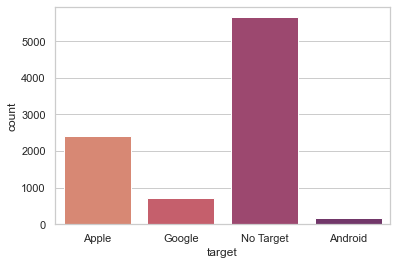

In [345]:
# target breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'target', data = df, palette = 'flare')

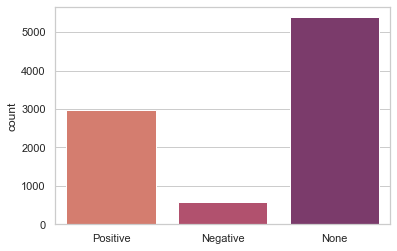

In [346]:
# emotion breakdown

sns.set(context = 'notebook', style = 'whitegrid', font_scale = 1)

ax = sns.countplot(x = 'emotion', data = df, palette = 'flare', order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product'])
ax.set(xlabel = '', xticklabels = ['Positive', 'Negative', 'None'])
plt.show()

In [150]:
# emotion breakdown by target

df.groupby(['target', 'emotion']).count()

text
target    emotion                                 
Android   Negative emotion                      16
          No emotion toward brand or product     2
          Positive emotion                     141
Apple     Negative emotion                     388
          No emotion toward brand or product    65
          Positive emotion                    1949
Google    Negative emotion                     115
          No emotion toward brand or product    24
          Positive emotion                     582
No Target Negative emotion                      51
          No emotion toward brand or product  5297
          Positive emotion                     306

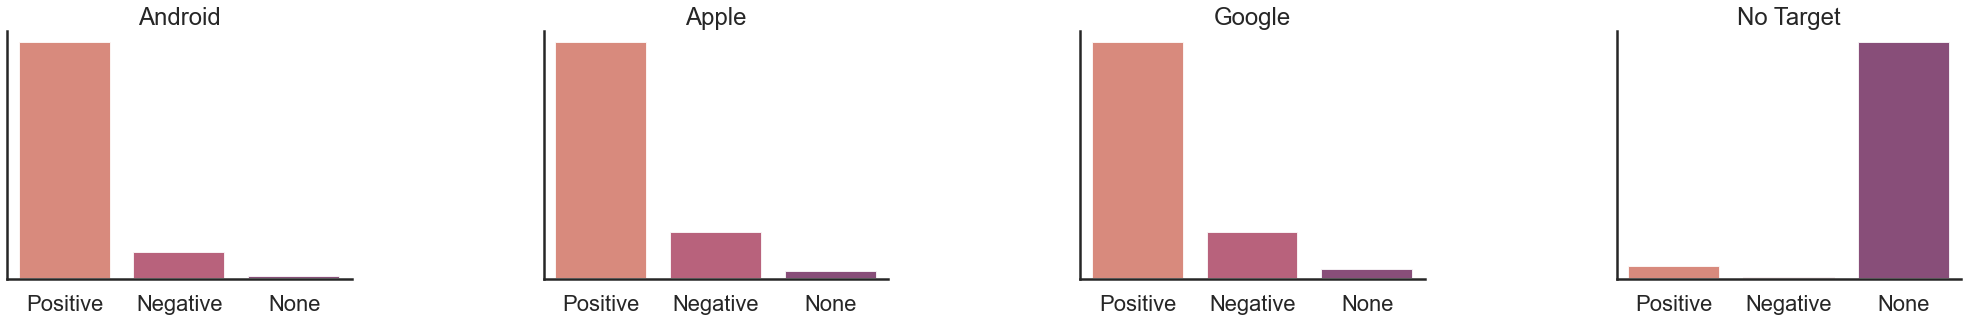

In [348]:
# emotion breakdown by target but fancier

sns.set(context = 'poster', style = 'white', font_scale = 1)
xlabel = ''
ylabel = ''
xticks = ['Positive', 'Negative', 'None']
yticks = ''
order = ['Positive emotion', 'Negative emotion', 'No emotion toward brand or product']
col_order = ['Android','Apple', 'Google', 'No Target']
ax = sns.catplot(data = df, x = 'emotion', col = 'target', kind = 'count', palette = 'flare', order = order, col_order = col_order, col_wrap = 4, sharey = False, height = 5, aspect = 1.5, alpha = 0.9)
ax.set(xlabel = xlabel, ylabel = ylabel, xticklabels = xticks, yticklabels = yticks, title = 'Tweet Emotion per Target')
ax.despine(left = False)
ax.set_titles('{col_name}')
plt.show()

# Text Cleaning

In [350]:
sw = stopwords.words('english')
sw.extend(['link', 'rt', 'sxsw'])
punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!'
twitter_re = re.compile('[#@][a-zA-Z]*')
num_re = re.compile('^\d{1}$')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def txt_clean(txt, stop_words=sw):
    # takes in a string and returns a cleaned up string ready for count or tfidf vectorizing
    
    # splitting the text up into words
    t = txt.split(' ')
    # turning the words lowercase
    t = [w.lower() for w in t]
    # removing punctuation
    t = [w.translate(w.maketrans('','', punctuation)) for w in t]
    # removing @'s and #'s which are twitter jargon
    t = [w for w in t if not twitter_re.match(w)]
    # removing leftover numbers
    t = [w for w in t if not num_re.match(w)]
    # removing stop words and more twitter jargon
    t = [w for w in t if w not in stop_words]
    # removing empty strings
    t = [w for w in t if w]
    # word lemmatizing
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    # joining all the strings together into one
    return ' '.join(t)

df['txt_cleaned'] = df['text'].map(txt_clean)

# Data Preprocessing 

In [351]:
# divides data into X and y, and then turns the model target labels into numerical format

X = df['txt_cleaned']
y = df['emotion'].replace(to_replace = {'Positive emotion' : 0, 'Negative emotion' : 1, 'No emotion toward brand or product': 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X, y, random_state = 42, test_size = 0.25)

## Count Vectorizer

In [330]:
cv = CountVectorizer(ngram_range = (1,1))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

google    1629
ipad      1610
apple     1337
store     1111
iphone     912
new        801
launch     617
austin     614
app        585
amp        550
get        521
social     469
popup      427
today      422
circle     397
open       362
dtype: int64

In [343]:
cv = CountVectorizer(ngram_range = (2,2))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

apple store        406
social network     338
new social         308
google launch      255
network call       239
popup store        235
major new          220
call circle        219
launch major       213
apple open         201
possibly today     179
circle possibly    170
temporary store    153
iphone app         152
downtown austin    138
ûï mention         134
dtype: int64

In [332]:
cv = CountVectorizer(ngram_range = (3,3))
X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

X_val_vec = cv.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(cv.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

new social network          288
social network call         238
major new social            219
network call circle         215
launch major new            213
google launch major         191
call circle possibly        168
circle possibly today       168
store downtown austin       117
apple popup store           109
open temporary store        102
apple open temporary        101
popup apple store            88
temporary store downtown     76
open popup store             59
popup store austin           58
dtype: int64

## Tfidf Vectorizer

In [341]:
tfidf = TfidfVectorizer(ngram_range = (1,1))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

google    240.070183
ipad      239.313802
apple     237.632293
store     226.393209
new       162.711539
iphone    154.285919
launch    148.994622
austin    136.084765
app       122.482337
social    119.411485
popup     114.957042
circle    111.338631
get       110.282754
today     105.922447
open      103.679951
amp       103.653888
dtype: float64

In [339]:
tfidf = TfidfVectorizer(ngram_range = (2,2))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.mean(axis = 0).sort_values(ascending = False)[:16]

social network     0.012308
apple store        0.012096
new social         0.011531
google launch      0.010132
network call       0.009756
call circle        0.009130
major new          0.009073
launch major       0.008921
popup store        0.008492
apple open         0.007962
possibly today     0.007875
circle possibly    0.007614
temporary store    0.006439
store austin       0.005648
downtown austin    0.005518
open popup         0.005502
dtype: float64

In [335]:
tfidf = TfidfVectorizer(ngram_range = (3,3))
X_t_vec = tfidf.fit_transform(X_t)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace = True)

X_val_vec = tfidf.transform(X_val)
X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace=True)

X_t_vec.sum(axis = 0).sort_values(ascending = False)[:16]

new social network          75.055583
social network call         65.934683
network call circle         61.617262
major new social            61.490357
launch major new            60.650786
google launch major         56.202533
call circle possibly        51.444224
circle possibly today       51.404848
store downtown austin       32.463873
open temporary store        32.266053
apple open temporary        31.137155
apple popup store           30.134933
temporary store downtown    24.456426
popup apple store           22.100222
open popup store            20.703297
popup store austin          20.361929
dtype: float64

In [336]:
X_t_vec

,02 symbian window,03 blackberry 02,0310 weve get,031111 cover social,0610 316 austin,10 app licence,10 app update,10 attendee mac,10 austin airport,10 austin classic,...,ûó longtime mac,ûó marissa mayer,ûó maybe via,ûó novelty news,ûó quotapple open,ûó theft public,ûócan tell white,ûólewis carroll crowd,ûómy iphone almost,ûóthe right house
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# FSM: Binomial Naive Bayes

In [344]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)
y_hat = mnb.predict(X_val_vec)
confusion_matrix(y_val, y_hat)

array([[ 325,    3,  391],
       [  31,   30,   98],
       [ 191,    9, 1156]], dtype=int64)